## Querying Relational Databases

- Databases usually have multiple tables
- Tables have different but related data
- Often reference or relate to each other by a key
- Make connections by **JOIN**ing


## movielens data set

- Full dataset: [grouplens.org/datasets/movielens](http://grouplens.org/datasets/movielens/)
    - 27,000 movies
    - 470,000 tags
    - 21,000,000 ratings
    - by 230,000 users - anonymized
- We'll be working with a subset in SQLite format **movielens-small**

## Reading the data

Open the **querying-movielens.ipynb** notebook from the [day2-data.zip file](http://cliburn.github.io/cfar-data-workshop-2015/)



In [2]:
from sqlite_utils import SQLiteDatabase
ml = SQLiteDatabase('movielens-small.db')

In [3]:
# Know your limits
ml.query("SELECT * FROM movies") 

movieId,title,year,genres
1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji,1995,Adventure|Children|Fantasy
3,Grumpier Old Men,1995,Comedy|Romance
4,Waiting to Exhale,1995,Comedy|Drama|Romance
5,Father of the Bride Part II,1995,Comedy
6,Heat,1995,Action|Crime|Thriller
7,Sabrina,1995,Comedy|Romance
8,Tom and Huck,1995,Adventure|Children
9,Sudden Death,1995,Action
10,GoldenEye,1995,Action|Adventure|Thriller


### Review on row order

- No inherent order in the rows - reference them by a unique value and not a position.
- movieId is a **PRIMARY KEY**. It's an identifier that must be different for every movie
- Can order by multiple columns, let's try year then title...


### Exercise:

Query (`SELECT`) the **movies** table, sorting by **year** (newest first) then **title** (A-Z)

`... ORDER BY <column 1> (ASC|DESC), <column 2> (ASC|DESC)`

What's the first movie listed? The last?

In [4]:
# movies by year (newest) then by title (a-z)
ml.query('SELECT * from movies order by year desc, title asc')

movieId,title,year,genres
125916,Fifty Shades of Grey,2015,Drama
120825,The Woman in Black 2: Angel of Death,2015,Drama|Horror|Thriller
110286,13 Sins,2014,Horror|Thriller
112138,22 Jump Street,2014,Action|Comedy|Crime
109569,3 Days to Kill,2014,Action|Crime|Drama
109673,300: Rise of an Empire,2014,Action|Drama|War|IMAX
112940,A Most Wanted Man,2014,Thriller
113557,Age of Tomorrow,2014,Action|Sci-Fi|Thriller
114662,American Sniper,2014,Action|War
113780,"As Above, So Below",2014,Horror|Thriller


In [5]:
ml.query("SELECT * FROM ratings")

userId,movieId,rating,timestamp
1,6,2.0,980730861
1,22,3.0,980731380
1,32,2.0,980731926
1,50,5.0,980732037
1,110,4.0,980730408
1,164,3.0,980731766
1,198,3.0,980731282
1,260,5.0,980730769
1,296,4.0,980731208
1,303,3.0,980732235


## Ratings table

- The rating itself is a number (e.g. number of stars)
- Each rating has a **userId**, **movieId**, and **timestamp**
    - Timestamp is seconds since Jan 1, 1970


In [6]:
# Can convert with python
import time
time.ctime(980730861)

'Sun Jan 28 20:14:21 2001'

In [7]:
# Or in SQL:
ml.query("SELECT *, datetime(timestamp, 'unixepoch') as date from ratings limit 3")

userId,movieId,rating,timestamp,date
1,6,2.0,980730861,2001-01-29 01:14:21
1,22,3.0,980731380,2001-01-29 01:23:00
1,32,2.0,980731926,2001-01-29 01:32:06


### Relationship to movies
- We have a **movies** table also with a **movieId**
- We can look up ratings for a movie, but we need to know its **movieId**

That common **movieId** column is a **KEY**

- In the **movies** table, it's a **PRIMARY KEY**
- In the **ratings** table, it's a **FOREIGN KEY**

## Exercise: Relational Data

Look up a favorite movie and find newest and oldest rating.

Tips:
- Titles like **The Godfather** are listed as **Godfather, The**
- Sorting the **timestamp** column can be used to find the oldest (ASC) or newest (DESC)
- Can use `datetime(timestamp, 'unixepoch')`

In [8]:
ml.query("select title, movieId from movies where title like 'Godfather%'")

title,movieId
"Godfather, The",858
"Godfather: Part II, The",1221
"Godfather: Part III, The",2023


In [9]:
ml.query("SELECT * FROM ratings WHERE movieId = 858 ORDER BY timestamp ASC")

userId,movieId,rating,timestamp
343,858,4.0,846463100
274,858,4.0,846765476
139,858,5.0,848324493
503,858,5.0,859134568
448,858,4.0,859401801
307,858,4.0,860349423
147,858,5.0,861218317
524,858,5.0,861875896
266,858,4.0,862150161
632,858,5.0,862942268


### Aggregate Functions

- Not practical to query/scan individual ratings
- Even with Pandas, you may not want hold the dataset in memory. Ask for what you want.
- Functions like average, count, can be part of the query.

[SQLite Aggregate Functions](https://www.sqlite.org/lang_aggfunc.html)

- avg
- count
- max / min
- sum
- group_concat 

In [27]:
ml.query("SELECT count(rating), avg(rating), max(rating), min(rating) FROM ratings WHERE movieId = 858")
# How many ratings does your movie have?
# What's the average rating for your movie?

count(rating),avg(rating),max(rating),min(rating)
208,4.33413461538,5.0,0.5


### Distinct

Distinct is often used with these aggregate functions, especially with values that repeat across rows, like a year.

In [11]:
 # How many years in the table? What's the max and min?
ml.query("SELECT DISTINCT(year) FROM movies order by year limit 200")

year
None
1902
1915
1916
1919
1920
1921
1922
1923
1924


In [12]:
ml.query("select movieId from movies where title like 'Shawshank%'")
ml.query("select sum(rating) from ratings where movieId = 318")

sum(rating)
1457.0



### Exercise: Aggregates

The full dataset has:
- 27,000 movies
- 470,000 tags
- 21,000,000 ratings
- by 230,000 users


1. What are these statistics for the tables in your database?
2. What's the average rating for all movies?
3. If each rating is a star, how many **total** stars have been given for **Shawshank Redemption, The**
4. What's the date of the oldest rating? The newest?

Hint:
- No users table but userIds exist in ratings


# Querying Multiple Tables

Joins and keys

The real power of relational databases is in the **relations**.

movies and ratings are related, but there are other tables:

- movies:links is 1:1
- movies:ratings 1:Many
- movies:tags is Many:Many

Connect related tables in a single query, with a **JOIN**

### JOIN Query

Let's have a look at the links table, and see how we can get the IMDB link for some movies in the table.

In [13]:
# Start with SELECT movies.title FROM movies
ml.query('''
SELECT movies.title, links.* from movies 
    JOIN links ON movies.movieId = links.movieId''')
# JOIN links ON movies.movieId = links.movieId

title,movieId,imdbId,tmdbId
Toy Story,1,0114709,862
Jumanji,2,0113497,8844
Grumpier Old Men,3,0113228,15602
Waiting to Exhale,4,0114885,31357
Father of the Bride Part II,5,0113041,11862
Heat,6,0113277,949
Sabrina,7,0114319,11860
Tom and Huck,8,0112302,45325
Sudden Death,9,0114576,9091
GoldenEye,10,0113189,710


In [14]:
movies_links = '''
SELECT movies.title, links.*
FROM movies
JOIN links on movies.movieId = links.movieId
'''
ml.query(movies_links)

title,movieId,imdbId,tmdbId
Toy Story,1,0114709,862
Jumanji,2,0113497,8844
Grumpier Old Men,3,0113228,15602
Waiting to Exhale,4,0114885,31357
Father of the Bride Part II,5,0113041,11862
Heat,6,0113277,949
Sabrina,7,0114319,11860
Tom and Huck,8,0112302,45325
Sudden Death,9,0114576,9091
GoldenEye,10,0113189,710


### Exercise

Write a query that JOINs movies and links to print titles and links for each of the Star Wars movies

In [15]:
starwars_links = '''
SELECT movies.title, links.*
FROM movies
JOIN links ON movies.movieId = links.movieId
WHERE movies.title like 'Star Wars: Episode%'
'''
ml.query(starwars_links)

title,movieId,imdbId,tmdbId
Star Wars: Episode IV - A New Hope,260,0076759,11
Star Wars: Episode V - The Empire Strikes Back,1196,0080684,1891
Star Wars: Episode VI - Return of the Jedi,1210,0086190,1892
Star Wars: Episode I - The Phantom Menace,2628,0120915,1893
Star Wars: Episode II - Attack of the Clones,5378,0121765,1894
Star Wars: Episode III - Revenge of the Sith,33493,0121766,1895


In [28]:
starwars_links = '''
SELECT
    movies.title,
    links.*
FROM movies
JOIN links on movies.movieId = links.movieId
WHERE movies.title like 'Star Wars: Episode%'
ORDER BY movies.title asc
'''
ml.query(starwars_links)

title,movieId,imdbId,tmdbId
Star Wars: Episode I - The Phantom Menace,2628,0120915,1893
Star Wars: Episode II - Attack of the Clones,5378,0121765,1894
Star Wars: Episode III - Revenge of the Sith,33493,0121766,1895
Star Wars: Episode IV - A New Hope,260,0076759,11
Star Wars: Episode V - The Empire Strikes Back,1196,0080684,1891
Star Wars: Episode VI - Return of the Jedi,1210,0086190,1892


### Joins and Aggregates

We can join tables and we can run aggregate functions like AVG/COUNT, useful to put those together.

Average rating for all the star wars movies

In [17]:
# Start with a query, then add the aggregates
ratings_query = '''
SELECT AVG(ratings.rating)
FROM movies
JOIN ratings ON movies.movieId = ratings.movieId
WHERE movies.title like 'Star Wars: Episode%'
LIMIT 100'''
ml.query(ratings_query)

AVG(ratings.rating)
3.86371923428


### Exercise

Starting with the average ratings of Star Wars query:

1. How many ratings? How many total stars?
2. How does the average rating of the first 3 (before 1999) compare to the second 3 (after 1999)?
4. How does the average rating of these movies compare to the Godfather trilogy?


## Grouping

When aggregating, often makes sense aggregate groups of data instead of whole dataset

For example: average rating for each movie instead of all movies

This is called grouping, we covered it in Pandas, and it's also possible in SQL.


In [18]:
ml.query('select year, count(*) FROM movies GROUP BY year limit 200')

year,count(*)
None,2
1902,1
1915,1
1916,1
1919,2
1920,1
1921,1
1922,4
1923,3
1924,3


### Exercise: Grouping with Joins

Grouping works with any query, not just single-tables. 

Let's apply this to the ratings query from earlier, and see what that looks like

1. Include title (I'll get you started)
2. Include year
3. Include number of ratings as **num_ratings**
4. Order by the average rating (highest first)
5. Order by the most ratings (highest first)

In [19]:
ratings_query = '''
SELECT avg(ratings.rating) AS avg_rating,
count(ratings.rating) as num_ratings,
title
FROM movies
JOIN ratings ON movies.movieId = ratings.movieId
WHERE movies.title like 'Star Wars: Episode%'
GROUP BY movies.title
'''
ml.query(ratings_query)

avg_rating,num_ratings,title
3.13758389262,149,Star Wars: Episode I - The Phantom Menace
3.30113636364,88,Star Wars: Episode II - Attack of the Clones
3.37096774194,62,Star Wars: Episode III - Revenge of the Sith
4.19607843137,306,Star Wars: Episode IV - A New Hope
4.09756097561,246,Star Wars: Episode V - The Empire Strikes Back
3.98170731707,246,Star Wars: Episode VI - Return of the Jedi


### 5 Highest-Rated Movies

Let's write a query to find the 5 highest rated movies

We're pretty close, just need to remove the WHERE clause and add a LIMIT, right?

In [20]:
# 5 highest rated movies
ratings_query = '''
SELECT 
    movies.title, 
    avg(ratings.rating) AS avg_rating
FROM movies
JOIN ratings ON movies.movieId = ratings.movieId
GROUP BY movies.title 
ORDER BY avg_rating DESC
LIMIT 5
'''
ml.query(ratings_query)

title,avg_rating
35 Up,5.0
"36th Chamber of Shaolin, The (Shao Lin san shi liu fang) (Master Killer)",5.0
49 Up,5.0
9 Songs,5.0
Abbott and Costello Meet the Mummy,5.0


### HAVING
- A WHERE clause for aggregates


### Exercises

- Get movies with over 100 ratings and at least a 4 star average
- Get movies with at least 15 tags
- Include those tags with group_concat function

In [36]:
ratings_query = '''
SELECT 
    movies.title,
    movies.movieId, 
    avg(ratings.rating) AS avg_rating,
    count(ratings.rating) AS num_ratings
FROM
    movies
JOIN
    ratings ON movies.movieId = ratings.movieId
GROUP BY
    movies.title, movies.movieId
HAVING
    num_ratings > 100 AND avg_rating > 4.0
order by avg_rating desc
'''
ml.query(ratings_query)

title,movieId,avg_rating,num_ratings
"Shawshank Redemption, The",318,4.44207317073,328
"Usual Suspects, The",50,4.36820083682,239
"Godfather, The",858,4.33413461538,208
Schindler's List,527,4.3112033195,241
Casablanca,912,4.25968992248,129
"Godfather: Part II, The",1221,4.25,132
"Silence of the Lambs, The",593,4.23590504451,337
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,750,4.22619047619,126
"Matrix, The",2571,4.20754716981,265
Star Wars: Episode IV - A New Hope,260,4.19607843137,306


In [33]:
tags_query = '''
SELECT 
    movies.title, 
    movies.year,
    count(tags.tag) AS num_tags,
    group_concat(tags.tag) as all_tags
FROM
    movies
JOIN
    tags ON movies.movieId = tags.movieId
GROUP BY
    movies.title
HAVING
    num_tags > 15
order by year
'''
ml.query(tags_query)

title,year,num_tags,all_tags
"Evil Dead, The",1981,16,"Necronomicon,ancient book,black comedy,campy,cult horror,dark humor,demon possession,demons,evil spirits,heroic,isolation,occult,possession,stylish,undead,wilderness"
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark),1981,16,"AFI 100,Determined Hero,Nazis,Nazis,World War II,adventure,atmospheric,classic,good versus evil,great characters,great soundtrack,indiana jones,racism,racism,romance,treasure hunt"
Evil Dead II (Dead by Dawn),1987,17,"Bruce Campbell,Great Ending,Necronomicon,ancient book,black comedy,cult horror,dark humor,dark humor,demon possession,demons,evil spirits,heroic,isolation,occult,possession,undead,wilderness"
Beauty and the Beast,1991,20,"Disney,Disney animated feature,France,Oscar (Best Music - Original Score),Oscar (Best Music - Original Song),affectionate,animation,animation,beautiful,fairy tale,fairy tale,fairy tales,gentle,heartwarming,heroine,humorous,kids and family,redemption,slow,whimsical"
"Shawshank Redemption, The",1994,18,"Morgan Freeman,Stephen King,Stephen King,Tim Robbins,atmospheric,crime,drama,inspirational,justice,powerful ending,prison,prison,prison escape,reflective,revenge,thought-provoking,twist ending,twist ending"
Seven (a.k.a. Se7en),1995,19,"captivating,crime,dark,disturbing,disturbing,drama,greed,horror,investigation,police,powerful ending,psychology,serial killer,shocking,thriller,thriller,twist ending,twists & turns,violent"
Twelve Monkeys (a.k.a. 12 Monkeys),1995,17,"Post apocalyptic,complicated,dystopia,dystopia,future,genetics,post-apocalyptic,post-apocalyptic,psychology,psychology,sci-fi,sci-fi,time loop,time travel,twist ending,twist ending,violence"
"Matrix, The",1999,20,"Keanu Reeves,alternate reality,artificial intelligence,cult film,cyberpunk,dark hero,dystopia,dystopia,fight scenes,fight scenes,martial arts,martial arts,philosophy,philosophy,post apocalyptic,post apocalyptic,post-apocalyptic,surreal,thriller,virtual reality"
"Sixth Sense, The",1999,20,"AFI 100 (Thrills),Atmospheric,Drama,M. Night Shyamalan,cultural classic,enigmatic,ghosts,ghosts/afterlife,mindfuck,psychological,psychology,psychology,psychology,somber,surprise ending,suspense,twist ending,twist ending,twist ending,unique"
WALL·E,2008,21,"Expression through movement,Inventive,Post apocalyptic,Preachy,adventure,animated,animation,dystopia,dystopia,dystopia,environmental,environmental,family,heartfelt,love,original,physical comedy,pixar,post-apocalyptic,post-apocalyptic,romance"


### Putting it all together

- Plotting avg score by year



In [22]:
# Imports for pandas, sqlite, and plt
import pandas as pd
from pandas import DataFrame as df
import sqlite3
import matplotlib.pyplot as plt

In [23]:
# Build up the query as a string
ratings_query = '''
SELECT 
    movies.year,
    avg(ratings.rating) as avg_rating,
    count(ratings.rating) as num_ratings
FROM
    movies
JOIN
    ratings ON movies.movieId = ratings.movieId
GROUP BY
    movies.year
order by year
'''

# Create a Data Frame from the query
conn = sqlite3.connect('movielens-small.db')
ratings_by_year = pd.read_sql_query(ratings_query, conn)
conn.close()


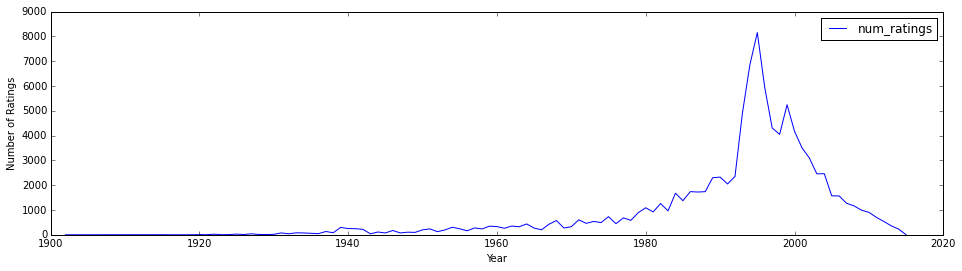

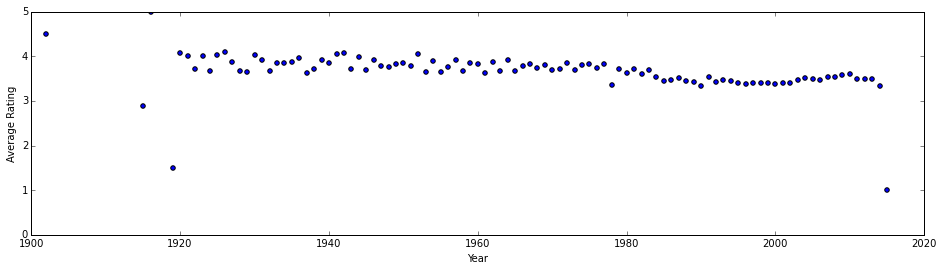

In [24]:
# Tell Matplotlib to plot inline
%matplotlib inline

# Generate some plots from the data frame
ratings_by_year.plot(kind='line', x='year', y='num_ratings', xlim=(1900,2020), figsize=(16,4))
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

ratings_by_year.plot(kind='scatter', x='year', y='avg_rating', xlim=(1900,2020), ylim=(0,5), figsize=(16,4))
plt.xlabel('Year')
plt.ylabel('Average Rating')

pass

In [25]:
ratings_by_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
year           100 non-null float64
avg_rating     101 non-null float64
num_ratings    101 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


The Data Frame built from the aggregate query uses about 3KB

In [26]:
big_query = '''
SELECT 
    movies.year,
    ratings.rating
FROM
    movies
JOIN
    ratings ON movies.movieId = ratings.movieId
order by year'''
conn = sqlite3.connect('movielens-small.db')
all_ratings_and_year = pd.read_sql_query(big_query, conn)
conn.close()

all_ratings_and_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100023 entries, 0 to 100022
Data columns (total 2 columns):
year      100021 non-null float64
rating    100023 non-null float64
dtypes: float64(2)
memory usage: 2.3 MB


The data frame containing all ratings for all movies uses about 2.3MB - 750x more